# Validation of reference implementation
This notebook demonstrates that the reference WDD implementation reconstructs an object quantitatively. The result is almost exactly equal to the initial object bandpass filtered with an aperture twice as large as the illuminating aperture.

In [1]:
%matplotlib nbagg
#%load_ext line_profiler

In [2]:
import numpy as np
import scipy.ndimage

import matplotlib.pyplot as plt

In [3]:
from ptychography40.reconstruction.common import wavelength

In [4]:
def imshow_colorbar(axes, title, *args, **kwargs):
    axes.title.set_text(title)
    im = axes.imshow(*args, **kwargs)
    plt.colorbar(im, ax=axes)

## Define parameters for the initial simulation

Instead of measured data we use a simulation that is better suited to verify the calculation.

In [5]:
size = 64
semiconv = 0.087  # radian
lmbda = wavelength(300)  # 300 kV
pixel_size_real_sim = 0.5 * lmbda/size*256  # Simulate at high resolution
# One pixel in the diffracted space corresponds to the entire size in real space.
pixel_size_detector_sim = 1/size/pixel_size_real_sim*lmbda

In [6]:
lmbda, pixel_size_real_sim, pixel_size_detector_sim

(1.9687489006848795e-12, 3.937497801369759e-12, 0.0078125)

## Create an object

This object has low symmetry and contains a wave modulation, which leaves a characteristic signature in the diffraction pattern.

In [7]:
obj = np.ones((size, size), dtype=np.complex64)
y, x = np.ogrid[-size//2:size//2, -size//2:size//2]

outline = (((y*1.2)**2 + x**2) > (110/256*size)**2) & ((((y*1.2)**2 + x**2) < (120/256*size)**2))
obj[outline] = 0.0

left_eye = ((y + 40/256*size)**2 + (x + 40/256*size)**2) < (20/256*size)**2
obj[left_eye] = 0
right_eye = (np.abs(y + 40/256*size) < 15/256*size) & (np.abs(x - 40/256*size) < 30/256*size)
obj[right_eye] = 0

nose = (y + 20/256*size + x > 0) & (x < 0) & (y < 10/256*size)

obj[nose] = (0.05j * x + 0.05j * y)[nose]

mouth = (((y*1)**2 + x**2) > (50/256*size)**2) & ((((y*1)**2 + x**2) < (70/256*size)**2)) & (y > 20/256*size)

obj[mouth] = 0

tongue = (((y - 50/256*size)**2 + (x - 50/256*size)**2) < (20/256*size)**2) & ((y**2 + x**2) > (70/256*size)**2)
obj[tongue] = 0

# This wave modulation introduces a strong signature in the diffraction pattern
# that allows to confirm the correct scale and orientation.
signature_wave = np.exp(1j*(3 * y + 7 * x) * 2*np.pi/size)

obj += 0.3*signature_wave - 0.3

#obj = 0.99 + 0.01*obj

<IPython.core.display.Javascript object>


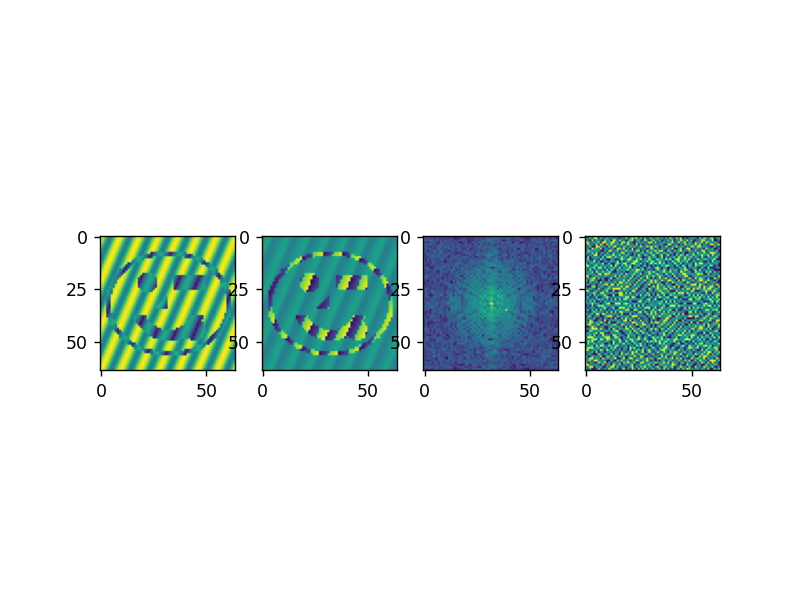

In [8]:
fig, axes = plt.subplots(1, 4)
axes[0].imshow(np.abs(obj))
axes[1].imshow(np.angle(obj))
axes[2].imshow(np.log1p(np.abs(np.fft.fftshift(np.fft.fft2(obj)))))
axes[3].imshow(np.angle(np.fft.fftshift(np.fft.fft2(obj))))

## Calculate the illumination

The illumination is first defined in radial space with a circular aperture, i.e. a convergent beam, as it is common in scanning transmission electron microscopy. It is then projected into the object plane using an inverse Fourier transform.

The `fftshift` takes care of proper shift to the center.

In [9]:
illum_radial = np.zeros((size, size), dtype=np.complex128)
#illum_radial[:] = np.exp(1j*(x**2 + y**2) / 5)
illum_radial[np.sqrt(y**2 + x**2) * pixel_size_detector_sim <= semiconv] = 17
# illum_radial[np.sqrt(y**2 + x**2) * pixel_size_detector_sim <= semiconv / 2] = 1j
#illum_radial[:] = np.random.random((size, size)) - 0.5 + 1j*np.random.random((size, size)) - 0.5j
#illum_radial *= 100

In [10]:
illum = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(illum_radial)))

<IPython.core.display.Javascript object>


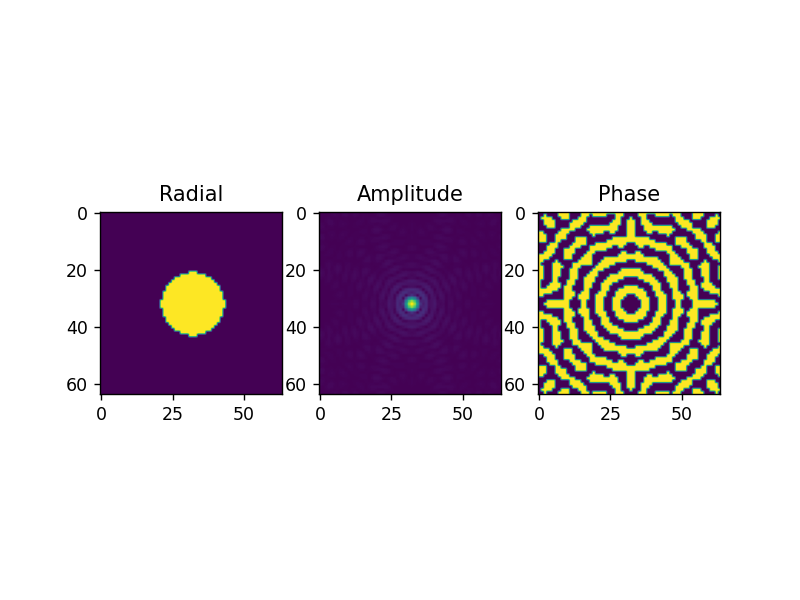

Text(0.5, 1.0, 'Phase')

In [11]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(np.abs(illum_radial))
axes[0].set_title("Radial")
axes[1].imshow(np.abs(illum))
axes[1].set_title("Amplitude")
axes[2].imshow(np.angle(illum))
axes[2].set_title("Phase")

## Forward simulation

Multiply the illumination with the object, project it to the far field and transform amplitude to intensity.

In [12]:
exitwave = illum * obj
projection = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(exitwave)))
diffpattern_sim = np.abs(projection)**2

<IPython.core.display.Javascript object>


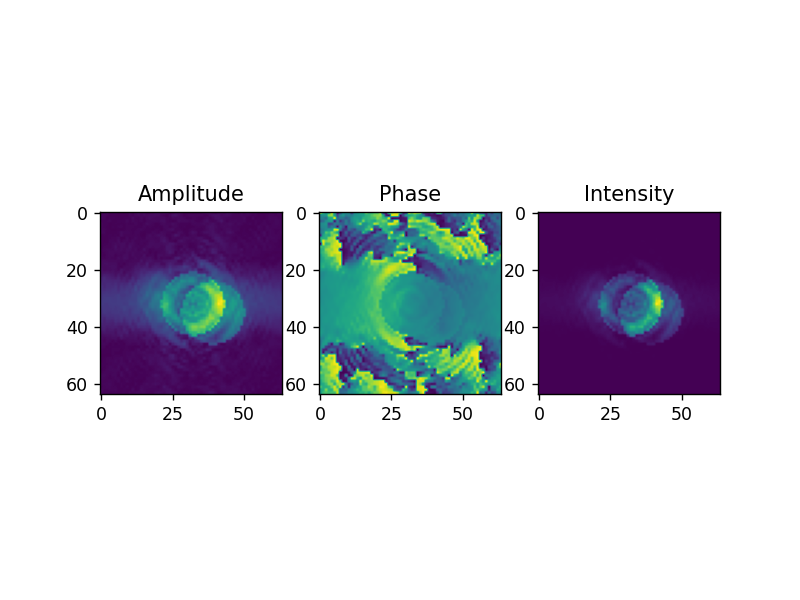

Text(0.5, 1.0, 'Intensity')

In [13]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(np.abs(projection))
axes[0].set_title("Amplitude")
axes[1].imshow(np.angle(projection))
axes[1].set_title("Phase")
axes[2].imshow(diffpattern_sim)
axes[2].set_title("Intensity")

## Simulated 4D STEM

In [14]:
data = np.zeros((size, size, size, size))
for y_shift in range(size):
    for x_shift in range(size):
        shifted_illum = np.roll(illum, (y_shift - size//2, x_shift - size//2), axis=(0, 1))
        projection = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift((obj * shifted_illum))))
        data[y_shift, x_shift] = np.abs(projection)**2

### Confirm difffraction pattern and correct placement of scan points

Plot a sample diffraction pattern and the value of the pixel at the optical axis as a function of scan position, corresponding to a TEM image

<IPython.core.display.Javascript object>


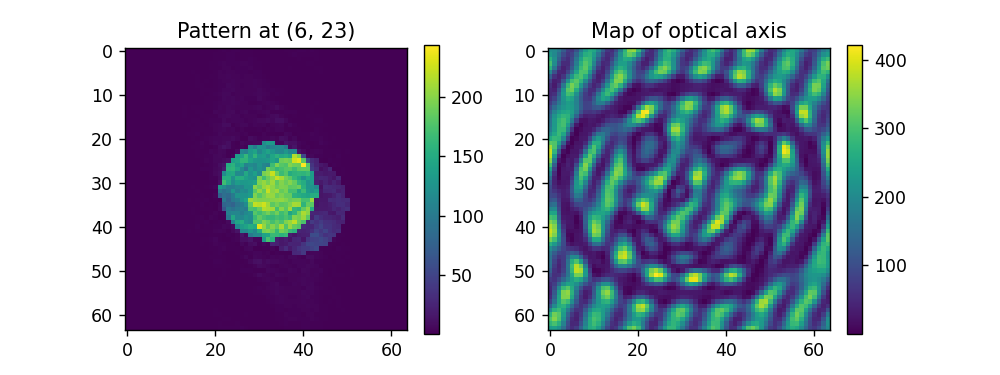

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
imshow_colorbar(axes[0], 'Pattern at (6, 23)', data[6, 23])
imshow_colorbar(axes[1], 'Map of optical axis', data[:, :, size//2, size//2])
fig.savefig('sample.svg')

## Simulated vacuum reference

Th same as the simulated 4D STEM data, just without multiplication of the object with the illumination, corresponding to an object with value 1 (vacuum).

In [16]:
vac_data = np.zeros((size, size, size, size))
for y_shift in range(size):
    for x_shift in range(size):
        shifted_illum = np.roll(illum, (y_shift - size//2, x_shift - size//2), axis=(0, 1))
        projection = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift((shifted_illum))))
        vac_data[y_shift, x_shift] = np.abs(projection)**2

## Illumination derived from vacuum reference

In [17]:
ref_illu_radial = np.sqrt(np.mean(vac_data, axis=(0, 1)))

## WDD reference implementation

In [18]:
def WDD(data, illu_radial, epsilon=0.01):
    WDD_Probe = np.zeros(data.shape,dtype=np.result_type(data, np.complex64))
    for scan_y_idx in range(data.shape[0]):
        for scan_x_idx in range (data.shape[1]):
            probe_function_n = np.roll(illu_radial, (scan_y_idx, scan_x_idx), axis=(0, 1))
            WDD_Probe[scan_y_idx, scan_x_idx]= np.fft.ifft2(illu_radial * np.conjugate(probe_function_n))

    data_4D_H = np.fft.fft2(np.fft.ifft2(data, axes=(2, 3)), axes=(0, 1))

    WDD_Obj =  WDD_Probe * data_4D_H / (np.abs(WDD_Probe)**2 + epsilon)
    data_4D_D = np.fft.fft2(WDD_Obj, axes=(2, 3))

    D00 = np.sqrt(data_4D_D[0, 0, 0, 0])
    obj_function = np.conj(np.fft.ifft2(data_4D_D[:, : , 0, 0]))/D00
    return (obj_function)

In [19]:
res = WDD(data, ref_illu_radial, epsilon=0.001)

In [20]:
com = np.zeros(data.shape[:2] + (2, ))

In [21]:
for yy in range(com.shape[0]):
    for xx in range(com.shape[1]):
        com[yy, xx] = scipy.ndimage.center_of_mass(data[yy, xx])

In [22]:
beam_center = scipy.ndimage.center_of_mass(np.abs(illum_radial))

In [23]:
com -= beam_center

In [24]:
from libertem_icom.udf.icom import iDPC

In [25]:
idpc_res = iDPC(com[..., 0], com[..., 1], np)

## Validate result

Compare object, WDD reconstruction, and bandpass-filtered object. The punctual deviations of the phase result from wrap-around at -pi / pi.

<IPython.core.display.Javascript object>


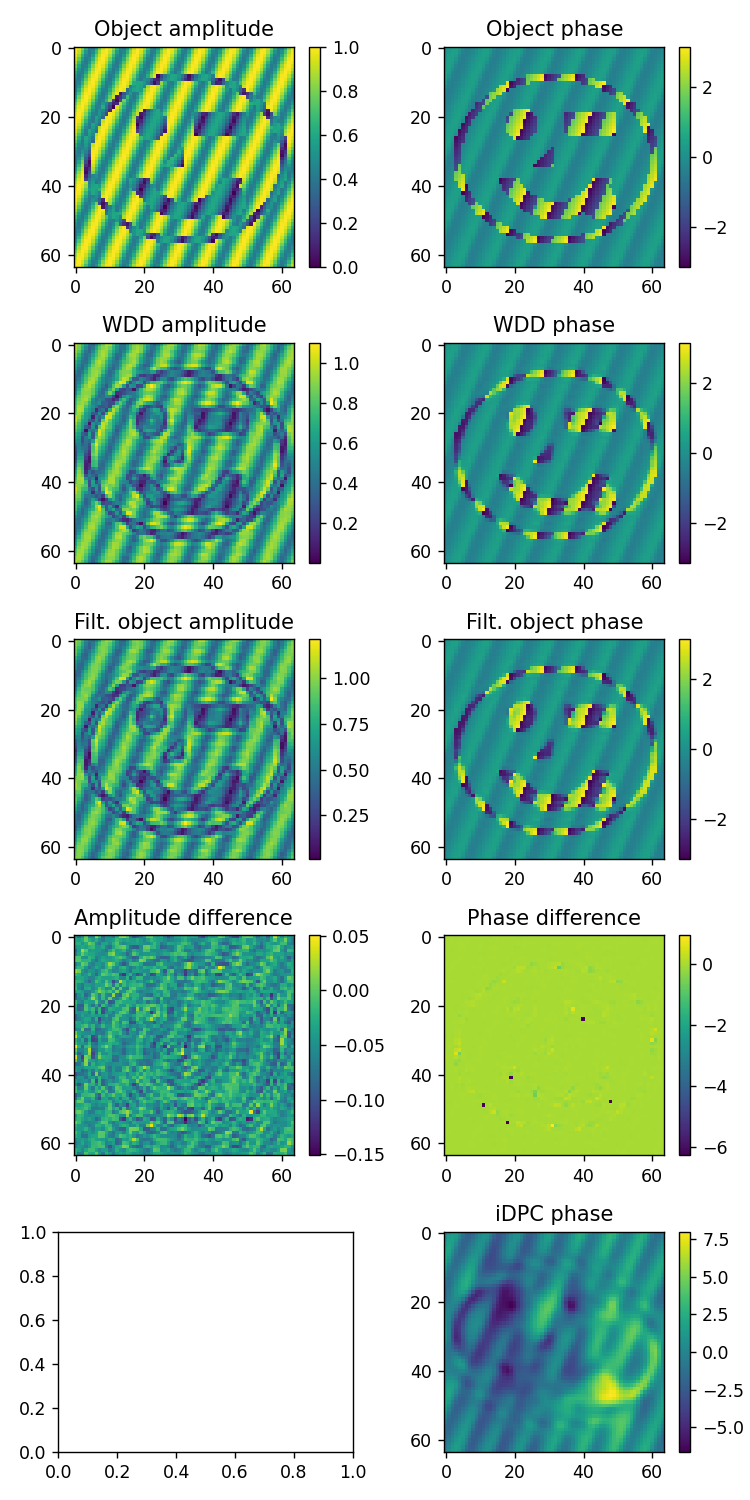

In [28]:
fig, axes = plt.subplots(5, 2, figsize=(6, 12))
imshow_colorbar(axes[0, 0], 'Object amplitude', np.abs(obj))
imshow_colorbar(axes[0, 1], 'Object phase', np.angle(obj))

imshow_colorbar(axes[1, 0], 'WDD amplitude', np.abs(res))
imshow_colorbar(axes[1, 1], 'WDD phase', np.angle(res))

filt = np.zeros((size, size), dtype=bool)
filt[np.sqrt(y**2 + x**2) * pixel_size_detector_sim <= 2*semiconv] = True
filt = np.fft.fftshift(filt)
filtered = np.fft.fftshift(np.fft.ifft2(filt * np.fft.fft2(np.fft.ifftshift(obj))))

imshow_colorbar(axes[2, 0], 'Filt. object amplitude', np.abs(filtered))
imshow_colorbar(axes[2, 1], 'Filt. object phase', np.angle(filtered))

imshow_colorbar(axes[3, 0], 'Amplitude difference', np.abs(res) - np.abs(filtered))
imshow_colorbar(axes[3, 1], 'Phase difference', np.angle(res) - np.angle(filtered))

imshow_colorbar(axes[4, 1], 'iDPC phase', idpc_res)

fig.tight_layout()
fig.savefig('validation.svg')